In [1]:
import pynbody as pnb
import astropy.constants as c
import astropy.units as u
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('/scratch/zwshao/Codes/intragroup-gas/')
from astropy.table import Table
import modules.cosmology as cos
import modules.gas_properties as g_p
import modules.halo_analysis as h_a
import modules.prepare_pyatomdb as ppat
from scipy.stats import binned_statistic as binstas

In [2]:
shuiyao_dir = '/scratch/rennehan/shuiyao_data/intragroup_props_p50n288'
shuiyao_type = ['desph', 'pesph', 'nL1']
snap_name='snapshot_108.hdf5'
filename = []
for i in shuiyao_type:
    filename.append(shuiyao_dir + i + '/' + snap_name)

In [3]:
num = 2
Filename = filename[num]
Filetype = shuiyao_type[num]
Save_filename = '/shuiyao/' + shuiyao_type[num]
s = pnb.load(filename[num])#, paramfile = paramfile)
s.physical_units()

/scratch/zwshao/anaconda3/lib/python3.7/site-packages/pynbody/snapshot/gadgethdf.py:508: RuntimeWarning: No unit information found!
  warnings.warn("No unit information found!", RuntimeWarning)
/scratch/zwshao/anaconda3/lib/python3.7/site-packages/pynbody/snapshot/gadgethdf.py:573: RuntimeWarning: No unit information found: using gadget-units.
  "No unit information found: using gadget-units.", RuntimeWarning)


In [4]:
dm_low_limit = 64*s.dm['mass'][0]
E_z = cos.Ez(s)

In [5]:
radius_field = ['vir', '200', '500', '2500']
masstype = ['star', 'gas', 'bar', 'ism', 'cold', 'igrm'] # used in Figure 8 of Liang et al.
radii_to_cal_sepcific_mass = ['200', '500']
specific_mass_field = []
for ra in radii_to_cal_sepcific_mass:
    specific_mass_field += [_masstype + ra for _masstype in masstype]
mass_field = radius_field + specific_mass_field + ['total_star', 'self_star']
temp_field = ['x', 'x_cont', 'mass', 'spec', 'spec_corr', \
                'x_corr', 'x_corr_cont', 'mass_corr']
entropy_field = ['500', '2500']
luminosity_field = ['x', 'x_cont', 'xb', 'xb_cont']
# _cont for only considering continuum emission, _corr for core-corrected (0.15*R500-R500)
# xb for broad band X-ray (0.1-2.4 keV) in our case.

default_field = {'R': radius_field, 'M': mass_field, 'T': temp_field, 'S': entropy_field, 'L': luminosity_field}
default_units = {'T': 'keV', 'L': 'erg s**-1', 'R': 'kpc', 'M': 'Msol', 'S': 'keV cm**2'}

In [6]:
host_prop_file = '/scratch/zwshao/Results/' + Save_filename + '_halo_infos_new_catalogue.hdf5'
temp_halo_info = {'M':{}, 'L':{}, 'T':{}, 'R':{}, 'S':{}}

with h5py.File(host_prop_file, "r") as f:
    quantity_dict = f.keys()
    for quan in quantity_dict:
        if quan in ['group_list', 'halo_id', 'N_lgal']:
            temp_halo_info[quan] = f[quan][:]
        else:
            detailed_quantity_dict = f[quan].keys()
            for d_quan in detailed_quantity_dict:
                temp_halo_info[quan][d_quan] = \
                        pnb.array.SimArray(f[quan][d_quan][:], units=f[quan][d_quan].attrs['units'])

In [7]:
ngal_dict = {0:[], 1:[], 2:[], 3:[]}# List of halos with n_gal >= 0, 1, 2, 3
G_masslist = {}
n_lgal_list = temp_halo_info['N_lgal']
for i in ngal_dict:
    ngal_dict[i] = np.where(n_lgal_list >= i)[0]

for i in range(4):
    G_masslist[i] = temp_halo_info['M']['vir'][ngal_dict[i]]

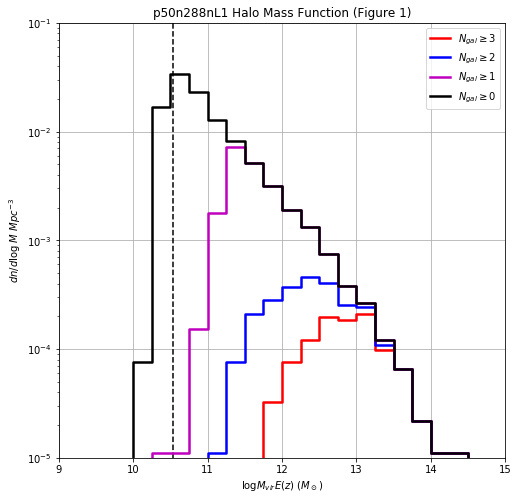

In [8]:
plt.figure(figsize=(8,8))
logmbins = np.linspace(9, 15, 25)
middle = logmbins[1:]# + logmbins[:-1])/2
binwidth = logmbins[1:]-logmbins[:-1]
vol = (s.properties['boxsize'].in_units('Mpc')/s.properties['a'])**3
vol2 = (25/0.68)**3
colors = ['r', 'b', 'm', 'k']
for j in range(4):
    i = 3-j
    hist = np.histogram(np.log10(G_masslist[i]*E_z), bins = logmbins)[0]
    hist = hist / (vol*binwidth)
    plt.plot(middle, hist, label=r'$N_{gal} \geq $' + '{}'.format(i), drawstyle='steps', linewidth=2.5, color=colors[j])
# hist2 = np.histogram(np.log10(AHFmass), bins=logmbins)[0]
# hist2 = hist2 / (vol2*binwidth)
# plt.plot(middle, hist2, label=r'AHF', drawstyle='steps', linestyle='dotted', color='k')
plt.vlines(np.log10(dm_low_limit), 1e-5, 1, linestyles='dashed', color='k')
plt.legend()
plt.yscale('log')
plt.xlim([9, 15])
plt.ylim([1e-5, 0.1])
plt.xlabel(r'$\log M_{vir}E(z)$ $(M_\odot)$')
plt.ylabel(r'$dn/d\log$ $M$ $Mpc^{-3}$')
plt.title('p50n288' + shuiyao_type[num] + ' Halo Mass Function (Figure 1)')
plt.grid()
plt.savefig('/scratch/zwshao/Results/' + Save_filename + 'Figure1.pdf')
plt.show()
plt.close()

In [9]:
group_L={} # Get group luminosities
group_M = {} # Get group masses.
group_T = {} # Get group temperatures.
group_S = {}
group_idx, = np.where(temp_halo_info['N_lgal'] >= 3)

for i in luminosity_field:
    j = 'L' + i
    group_L[i] = temp_halo_info['L'][i][group_idx].in_units('erg s**-1')

for i in mass_field:
    group_M[i] = temp_halo_info['M'][i][group_idx].in_units('Msol')
    
for i in temp_field:
    group_T[i] = temp_halo_info['T'][i][group_idx].in_units('keV')

for i in entropy_field:
    group_S[i] = temp_halo_info['S'][i][group_idx].in_units('keV cm**2')

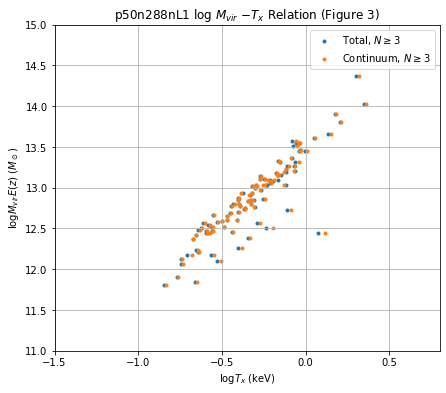

In [10]:
plt.figure(figsize=(4.6*1.5, 4*1.5))
# for g in set(two_galaxy_list) - set(group_list):
#     group = halo_prop[g]
#     plt.scatter(np.log10(group.T['x']), np.log10(group.M['vir'].in_units('Msol').view(np.ndarray)*E_z), \
#                     color='b', s=16)#, alpha=0.5, label=r'$N\geq 2$, total')
# #     plt.scatter(np.log10(group.T['x_cont']), np.log10(group.M['vir'].in_units('Msol').view(np.ndarray)*E_z), \
# #                     color='b', s=16, alpha=0.5, marker='s', label=r'$N\geq 2$, continuum')
plt.scatter(np.log10(group_T['x']), np.log10(group_M['vir'].in_units('Msol').view(np.ndarray)*E_z), \
                    s=9, label=r'Total, $N\geq 3$')#, label=r'$N\geq 3$, total')
#     plt.scatter(np.log10(group.T['x_cont']), np.log10(group.M['vir'].in_units('Msol').view(np.ndarray)*E_z), \
#                     color='r', s=16, alpha=0.5, marker='s', label=r'$N\geq 2$, continuum')
plt.scatter(np.log10(group_T['x_cont']), np.log10(group_M['vir'].in_units('Msol').view(np.ndarray)*E_z), \
                    s=9, label='Continuum, $N\geq 3$')


# plt.text(-1.4, 14.5, r'$N\geq 3$, total', color='r', fontsize=15)
# plt.text(-1.4, 14.3, r'$N\geq 3$, cont', color='g', fontsize=15)
plt.xlim([-1.5, 0.8])
plt.ylim([11, 15])
plt.grid()
plt.legend()
plt.xlabel(r'$\log T_{x}$ (keV)')
plt.ylabel(r'$\log M_{vir}E(z)$ $(M_\odot)$')
plt.title(r'p50n288' + shuiyao_type[num] + ' $\log$ $M_{vir}$ $-T_{x}$ Relation (Figure 3)')
plt.savefig('/scratch/zwshao/Results/' + Save_filename + 'Figure3.pdf')

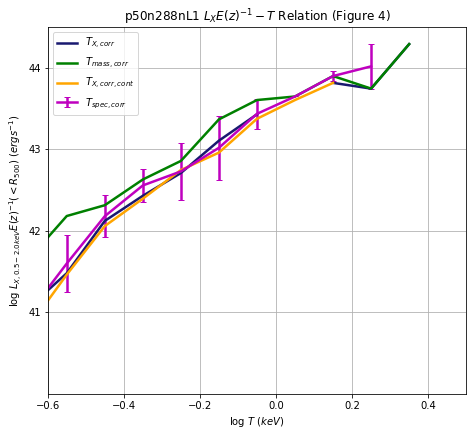

In [11]:
plt.figure(figsize=(5*1.5, 4.5*1.5))
tspec_corr_bins = np.linspace(-0.6-0.1, 0.4, 12)
middle = (tspec_corr_bins[:-1] + tspec_corr_bins[1:])/2

Tidx, = np.where(group_T['spec_corr'] > 0)
tspec_binresult = binstas(np.log10(group_T['spec_corr'][Tidx]), np.log10(group_L['x'][Tidx]/E_z), bins=tspec_corr_bins)
tspec_binerror = binstas(np.log10(group_T['spec_corr'][Tidx]), np.log10(group_L['x'][Tidx]/E_z), bins=tspec_corr_bins, statistic='std')

tx_binresult = binstas(np.log10(group_T['x_corr'][Tidx]), np.log10(group_L['x'][Tidx]/E_z), bins=tspec_corr_bins)
tmass_binresult = binstas(np.log10(group_T['mass_corr'][Tidx]), np.log10(group_L['x'][Tidx]/E_z), bins=tspec_corr_bins)
tx_cont_binresult = binstas(np.log10(group_T['x_corr_cont'][Tidx]), np.log10(group_L['x'][Tidx]/E_z), bins=tspec_corr_bins)

plt.errorbar(middle, y=tspec_binresult[0], yerr=tspec_binerror[0], \
                 label=r'$T_{spec, corr}$', capsize=3, linewidth=2.5, color='m')
plt.plot(middle, tx_binresult[0], label=r'$T_{X, corr}$', linewidth=2.5, color='midnightblue')
plt.plot(middle, tmass_binresult[0], label=r'$T_{mass, corr}$', linewidth=2.5, color='g')
plt.plot(middle, tx_cont_binresult[0], label=r'$T_{X, corr, cont}$', linewidth=2.5, color='orange')

plt.xlim([-0.6, 0.5])
plt.ylim([40, 44.5])
plt.yticks([41, 42, 43, 44])
plt.grid()
plt.xlabel(r'$\log$ $T$ $(keV)$')
plt.ylabel(r'$\log$ $L_{X, 0.5-2.0keV}E(z)^{-1}(<R_{500})$ $(ergs^{-1})$')
plt.title(r'p50n288' + shuiyao_type[num] + ' $L_X E(z)^{-1}-T$ Relation (Figure 4)')
plt.legend()
plt.savefig('/scratch/zwshao/Results/' + Save_filename + 'Figure4.pdf')
plt.show()
plt.close()

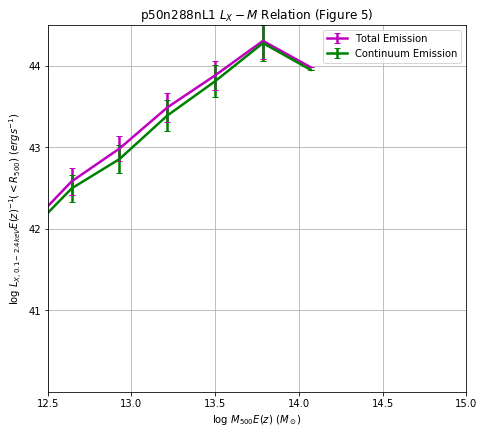

In [12]:
plt.figure(figsize=(5*1.5, 4.5*1.5))

tLxb_bins = np.linspace(12.5-2/7, 14.5, 9)
middle = (tLxb_bins[:-1] + tLxb_bins[1:])/2
Lidx, = np.where(group_L['xb'] > 0)
tLxb_binresult = binstas(np.log10(group_M['500'][Lidx]*E_z), np.log10(group_L['xb'][Lidx]/E_z), bins=tLxb_bins)
tLxb_binerror = binstas(np.log10(group_M['500'][Lidx]*E_z), np.log10(group_L['xb'][Lidx]/E_z), bins=tLxb_bins, statistic='std')

tLxbcont_binresult = binstas(np.log10(group_M['500'][Lidx]*E_z), np.log10(group_L['xb_cont'][Lidx]/E_z), bins=tLxb_bins)
tLxbcont_binerror = binstas(np.log10(group_M['500'][Lidx]*E_z), np.log10(group_L['xb_cont'][Lidx]/E_z), bins=tLxb_bins, statistic='std')

plt.errorbar(middle, y=tLxb_binresult[0], yerr=tLxb_binerror[0], \
                 label='Total Emission', capsize=3, color='m', linewidth=2.5)
plt.errorbar(middle, y=tLxbcont_binresult[0], yerr=tLxbcont_binerror[0], \
             label='Continuum Emission', capsize=3, color='g', linewidth=2.5)
plt.xlim([12.5, 15])
plt.ylim([40, 44.5])
plt.yticks([41, 42, 43, 44])
plt.grid()
plt.xlabel(r'$\log$ $M_{500}E(z)$ $(M_\odot)$')
plt.ylabel(r'$\log$ $L_{X, 0.1-2.4keV}E(z)^{-1}(<R_{500})$ $(ergs^{-1})$')
plt.title(r'p50n288' + shuiyao_type[num] + ' $L_X-M$ Relation (Figure 5)')
plt.legend()
plt.savefig('/scratch/zwshao/Results/' + Save_filename + 'Figure5.pdf')
plt.show()
plt.close()

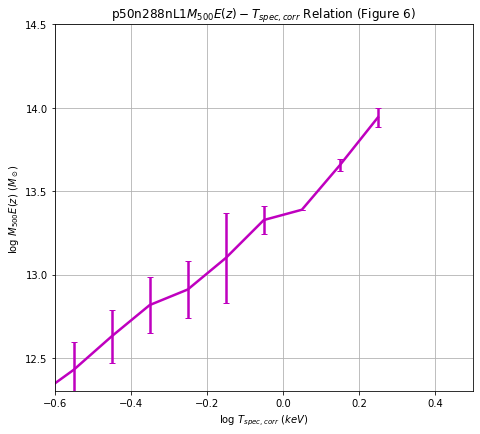

In [13]:
plt.figure(figsize=(5*1.5, 4.5*1.5))
tspec_corr_bins = np.linspace(-0.6-0.1, 0.4, 12)
middle = (tspec_corr_bins[:-1] + tspec_corr_bins[1:])/2
binresult = binstas(np.log10(group_T['spec_corr']), np.log10(group_M['500']*E_z), bins=tspec_corr_bins)
binerror = binstas(np.log10(group_T['spec_corr']), np.log10(group_M['500']*E_z), bins=tspec_corr_bins, statistic='std')
plt.errorbar(middle, y=binresult[0], yerr=binerror[0], capsize=3, color='m', linewidth=2.5)
plt.xlim([-0.6, 0.5])
plt.ylim([12.3, 14.5])
plt.yticks([12.5,13, 13.5, 14, 14.5])
plt.grid()
plt.xlabel(r'$\log$ $T_{spec, corr}$ $(keV)$')
plt.ylabel(r'$\log$ $M_{500}E(z)$ $(M_\odot)$')
plt.title(r'p50n288' + shuiyao_type[num] + '$M_{500}E(z)-T_{spec, corr}$ Relation (Figure 6)')
#plt.legend()
plt.savefig('/scratch/zwshao/Results/' + Save_filename + 'Figure6.pdf')
plt.show()
plt.close()

/scratch/zwshao/anaconda3/lib/python3.7/site-packages/pynbody/array.py:679: RuntimeWarning: invalid value encountered in greater
  return comparison_op(ar, other)


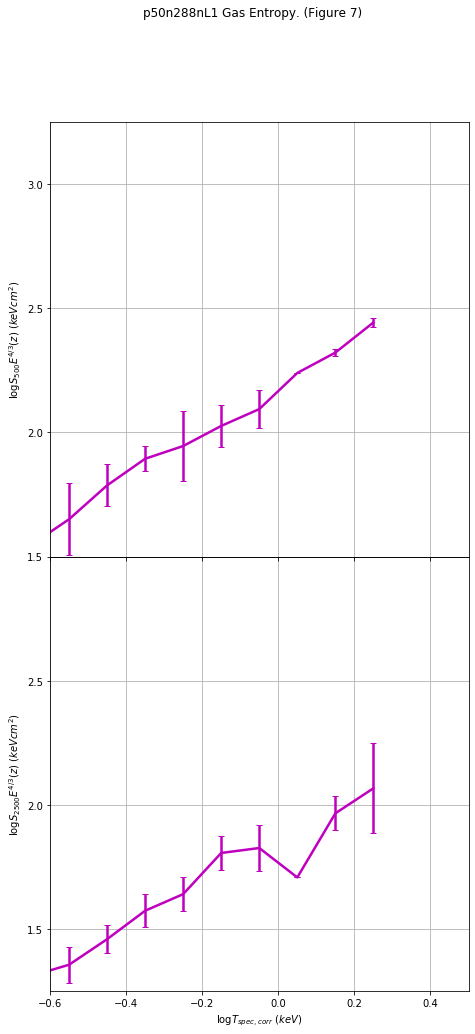

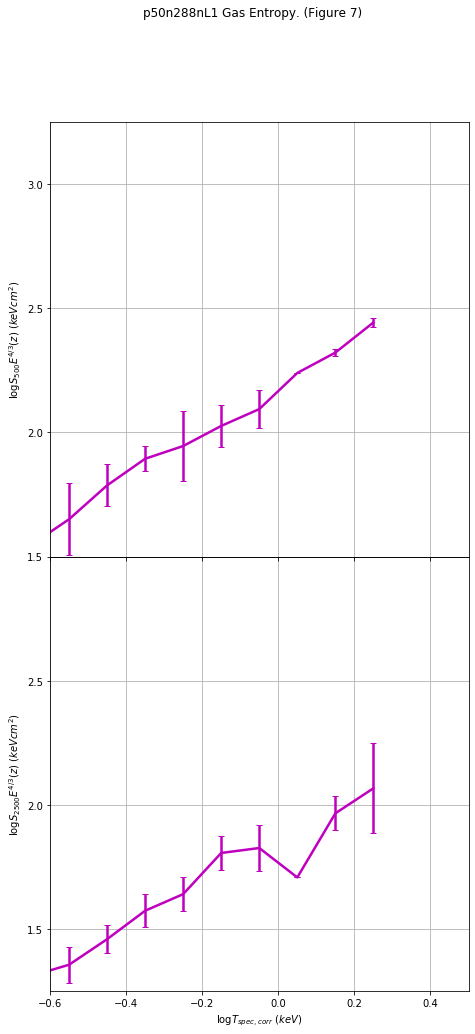

In [14]:
fig = plt.figure(figsize=(5*1.5, 16))
gs0 = fig.add_gridspec(2, 1, hspace=0)
ax = []

tspec_corr_bins = np.linspace(-0.6-0.1, 0.4, 12)
middle = (tspec_corr_bins[:-1] + tspec_corr_bins[1:])/2

idx500, = np.where((np.isnan(group_S['500']) == False) * (group_S['500'] > 0))
idx2500, = np.where((np.isnan(group_S['2500']) == False) * (group_S['2500'] > 0))

tS500_binresult = binstas(np.log10(group_T['spec_corr'][idx500]), np.log10(group_S['500'][idx500]*E_z**(4/3)), bins=tspec_corr_bins)
tS500_binerror = binstas(np.log10(group_T['spec_corr'][idx500]), np.log10(group_S['500'][idx500]*E_z**(4/3)), bins=tspec_corr_bins, statistic='std')

tS2500_binresult = binstas(np.log10(group_T['spec_corr'][idx2500]), np.log10(group_S['2500'][idx2500]*E_z**(4/3)), bins=tspec_corr_bins)
tS2500_binerror = binstas(np.log10(group_T['spec_corr'][idx2500]), np.log10(group_S['2500'][idx2500]*E_z**(4/3)), bins=tspec_corr_bins, statistic='std')

ax.append(fig.add_subplot(gs0[1]))
ax[-1].errorbar(middle, y=tS2500_binresult[0], yerr=tS2500_binerror[0], capsize=3, color='m', linewidth=2.5)
ax[-1].set_ylabel(r'$\log S_{2500}E^{4/3}(z)$ $(keV cm^2)$')
ax[-1].set_xlabel(r'$\log T_{spec, corr}$ $(keV)$')
ax[-1].set_ylim([1.25, 3])
ax[-1].set_xlim([-0.6, 0.5])
ax[-1].set_yticks([1.5, 2, 2.5])
ax[-1].grid()

ax.append(fig.add_subplot(gs0[0], sharex = ax[0]))
ax[-1].errorbar(middle, y=tS500_binresult[0], yerr=tS500_binerror[0], capsize=3, color='m', linewidth=2.5)
ax[-1].set_ylabel(r'$\log S_{500}E^{4/3}(z)$ $(keV cm^2)$')
ax[-1].set_ylim([1.5, 3.25])
ax[-1].set_yticks([1.5, 2, 2.5, 3])
ax[-1].grid()

plt.setp(ax[-1].get_xticklabels(), visible=False)
#plt.grid()

fig.suptitle('p50n288' + shuiyao_type[num] + ' Gas Entropy. (Figure 7)')
fig.savefig('/scratch/zwshao/Results/' + Save_filename + 'Figure7.pdf')
fig

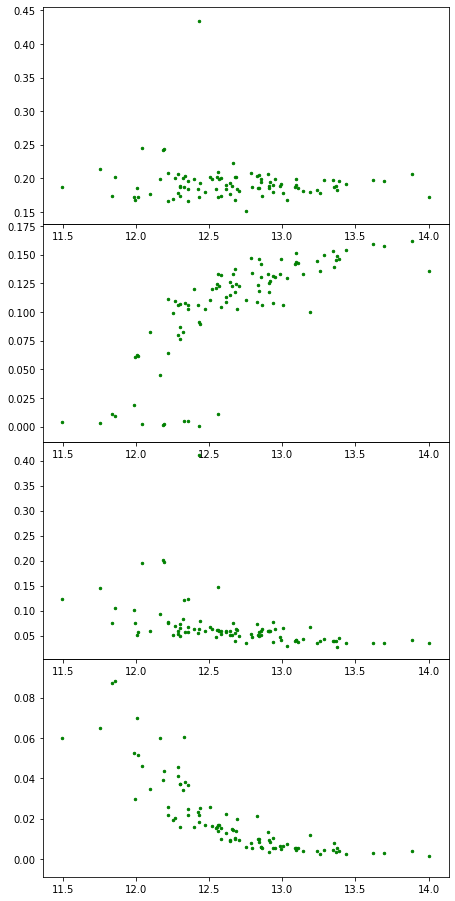

In [15]:
fig = plt.figure(figsize=(16, 16))
gs0 = fig.add_gridspec(4, 2, hspace=0)
grid1 = [[0,0],[1,0],[2,0],[3,0]]
ax1 = []
M_to_plot = ['bar500', 'igrm500', 'star500', 'cold500']
for j in range(len(M_to_plot)):
    i = len(M_to_plot) - 1 - j
    if j == 0:
        ax1.append(fig.add_subplot(eval('gs0'+str(grid1[i]))))
    else:
        ax1.append(fig.add_subplot(eval('gs0'+str(grid1[i])), sharex=ax1[0]))
    ax1[-1].scatter(np.log10(group_M['500']*E_z), group_M[M_to_plot[i]]/group_M['500'], color='g', s=6)

In [16]:
for i in range(4):
    if i != 0:
        plt.setp(ax1[i].get_xticklabels(), visible=False)
    ax1[i].set_ylim([0, 0.16])
    ax1[i].set_yticks([0, 0.04, 0.08, 0.12])
    if i == 3:
        ax1[i].set_ylim([0.04, 0.24])
        ax1[i].set_yticks([0.04, 0.08, 0.12, 0.16, 0.20, 0.24])
    if i == 2:
        ax1[i].set_ylim([0, 0.20])
        ax1[i].set_yticks([0, 0.04, 0.08, 0.12, 0.16])
ax1[3].hlines(0.176, 12.5, 14.5, color='k')
ax1[0].set_xlim([12.5, 14.5])
ax1[0].set_xlabel(r'$\log$ $M_{500}E(z)$ $(M_\odot)$')
ax1[0].set_ylabel(r'$M_{cold}/M_{500}$')
ax1[1].set_ylabel(r'$M_{*}/M_{500}$')
ax1[2].set_ylabel(r'$M_{IGrM}/M_{500}$')
ax1[3].set_ylabel(r'$M_{bar}/M_{500}$')

Text(9.575000000000017, 0.5, '$M_{bar}/M_{500}$')

In [17]:
grid2 = [[0,1],[1,1],[2,1],[3,1]]
ax2 = []
M_to_plot = ['bar200', 'igrm200', 'star200', 'cold200']
tm_bins = np.linspace(12.5-1.75/15, 14.425, 17)
middle = (tm_bins[:-1] + tm_bins[1:])/2
for j in range(len(M_to_plot)):
    i = len(M_to_plot) - 1 - j
    if j == 0:
        ax2.append(fig.add_subplot(eval('gs0'+str(grid2[i]))))
    else:
        ax2.append(fig.add_subplot(eval('gs0'+str(grid2[i])), sharex=ax2[0]))
        
    tm_binresult = binstas(np.log10(group_M['200']*E_z), \
                              group_M[M_to_plot[i]]/group_M['200'], bins=tm_bins)
    
    tm_binerror = binstas(np.log10(group_M['200']*E_z), \
                              group_M[M_to_plot[i]]/group_M['200'], bins=tm_bins, statistic='std')
    ax2[-1].errorbar(middle, y=tm_binresult[0], yerr=tm_binerror[0], color='g', capsize=3, linewidth=2.5)

In [18]:
for i in range(4):
    if i != 0:
        plt.setp(ax2[i].get_xticklabels(), visible=False)
    ax2[i].set_ylim([0, 0.16])
    ax2[i].set_yticks([0, 0.04, 0.08, 0.12])
    if i == 3:
        ax2[i].set_ylim([0.04, 0.24])
        ax2[i].set_yticks([0.04, 0.08, 0.12, 0.16, 0.20, 0.24])
    if i == 2:
        ax2[i].set_ylim([0, 0.20])
        ax2[i].set_yticks([0, 0.04, 0.08, 0.12, 0.16])
ax2[3].hlines(0.176, 12.5, 14.5, color='k')
ax2[0].set_xlim([12.5, 14.5])
ax2[0].set_xlabel(r'$\log$ $M_{200}E(z)$ $(M_\odot)$')
ax2[0].set_ylabel(r'$M_{cold}/M_{200}$')
ax2[1].set_ylabel(r'$M_{*}/M_{200}$')
ax2[2].set_ylabel(r'$M_{IGrM}/M_{200}$')
ax2[3].set_ylabel(r'$M_{bar}/M_{200}$')

Text(0, 0.5, '$M_{bar}/M_{200}$')

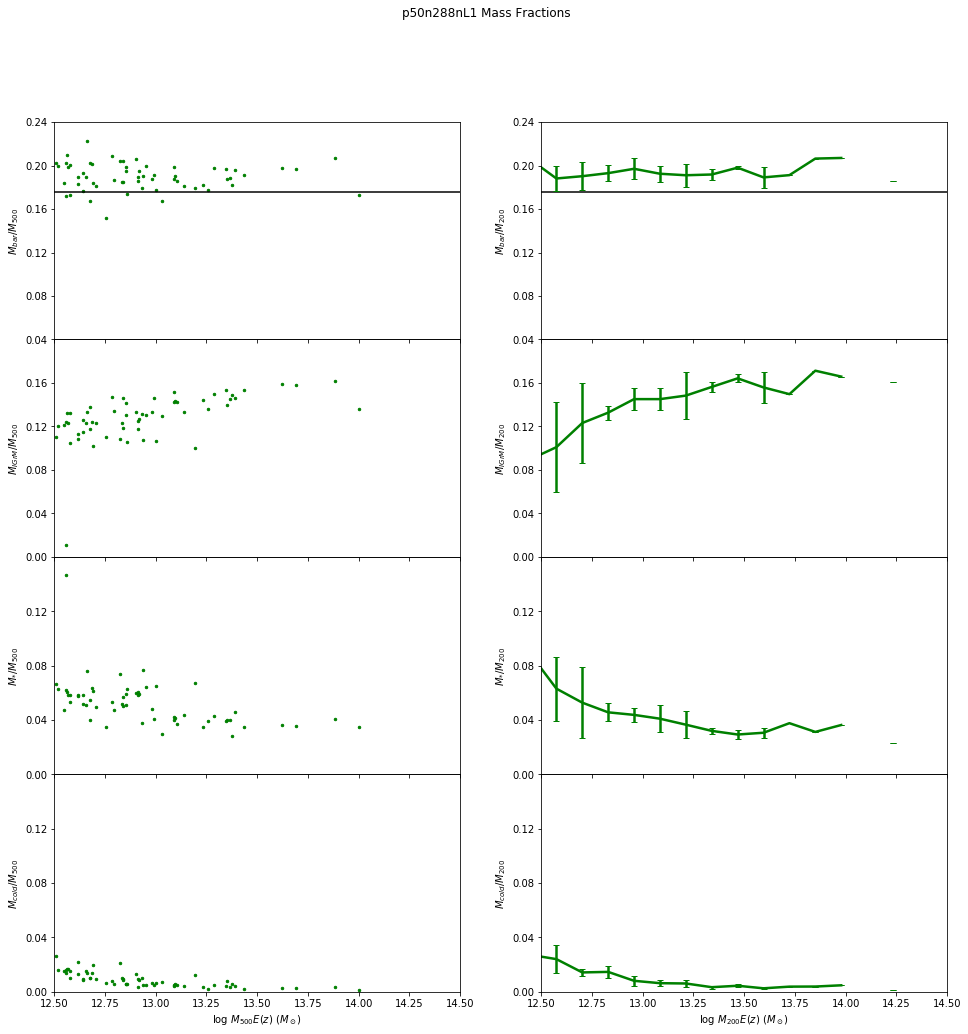

In [19]:
fig.suptitle('p50n288' + shuiyao_type[num] + ' Mass Fractions')
fig.savefig('/scratch/zwshao/Results/' + Save_filename + 'Figure8.pdf')
fig